In [38]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys
import pandas as pd

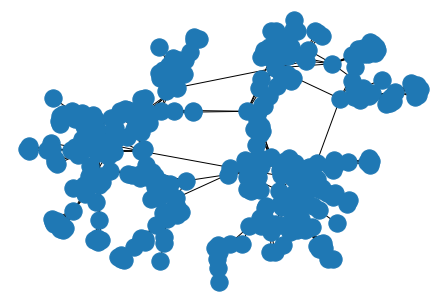

In [39]:
path = 'C:/Users/zuzan/OneDrive/Dokumenty/Master-Papers/real_networks/ca-netscience.txt'


df = pd.read_csv(path, delimiter = " ")

def extract_network(df):

    G = nx.from_pandas_edgelist(df,source='FromNodeId', target='ToNodeId')
    subgraphs=[G.subgraph(c) for c in nx.connected_components(G)]
    subgraphs_sizes = sorted([len(subgraph.nodes) for subgraph in subgraphs])
    
    mapping = {i:k for k,i in enumerate(list(G.nodes))}
    H=nx.relabel_nodes(G,mapping)
    
    return H


G = extract_network(df)

nx.draw(G)



In [40]:

def projection_simplex_pivot(v, z=1, random_state=None):
    rs = np.random.RandomState(random_state)
    n_features = len(v)
    U = np.arange(n_features)
    s = 0
    rho = 0
    while len(U) > 0:
        G = []
        L = []
        k = U[rs.randint(0, len(U))]
        ds = v[k]
        for j in U:
            if v[j] >= v[k]:
                if j != k:
                    ds += v[j]
                    G.append(j)
            elif v[j] < v[k]:
                L.append(j)
        drho = len(G) + 1
        if s + ds - (rho + drho) * v[k] < z:
            s += ds
            rho += drho
            U = L
        else:
            U = G
    theta = (s - z) / float(rho)
    return np.maximum(v - theta, 0)


def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


def crit_b(J):
    eigenvalues,_ = np.linalg.eig(J)
    return 1./np.max(np.abs(eigenvalues))

def average_degree(G,control,budget):
    return np.sum([G.degree[i]*con for i,con in enumerate(control)])/budget


In [41]:
        
class mf_ising_system:

    def __init__(self,graph,background_field,fixed_point_iter=500,init_mag='aligned',fp_tol_fac=10-6,
        iim_iter=1000,step_size=1.0,iim_tol_fac=1e-5):
        
        self.graph = graph
        self.adj_matrix = nx.to_numpy_matrix(graph)
        self.graph_size = len(graph.nodes.keys())
        self.background_field = background_field
        self.fixed_point_iter=fixed_point_iter
        self.iim_iter = iim_iter
        self.fp_tol_fac=fp_tol_fac
        self.iim_tol_fac=iim_tol_fac
        self.step_size=step_size
        if init_mag=='aligned':
            self.init_mag=np.zeros(self.graph_size)
        else:
            self.init_mag = init_mag 
            
        
    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = np.dot(self.adj_matrix[i],m)
        term = math.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term
    
    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(system.graph_size):
            m_new[i]=system.single_mag(i,m_old,beta,field)
        return m_new

    def Steffensen_method(self,mag,beta,field,mag_delta_history=[],it=0,heuristics=False):      
        # Numerical Analysis Richard L.Burden 9th Edition, p. 107
        if len(mag_delta_history)==0 or heuristics==True:
            mag0=mag
        else:
            mag0=mag_delta_history[it]
        
        for i in range(self.fixed_point_iter):     
            mag1=self.magnetisation(mag0,beta,field)
            mag2=self.magnetisation(mag1,beta,field)
            
            if np.all((mag+mag2-2*mag1)!=0):
                mag_d = mag - (mag1-mag)**2/(mag+mag2-2*mag1) 
            else:
                mag_d = mag1
            
                    
            if np.abs(np.mean(mag1)-np.mean(mag_d))<self.fp_tol_fac: 
                break
            if i+1==self.fixed_point_iter:
                print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.')
                mag_d = mag1
                if heuristics==True:
                    mag_d = None
                
        mag_delta_history.append(mag_d)
        return mag_d,mag_delta_history
    
    def mag_grad(self,beta,mag):
        # Mean Field Susceptibility;
        
        if all([math.isclose(i,j,abs_tol=1e-5) for i,j in zip(mag,np.ones(len(mag)))]):
            gradient = np.zeros(len(mag))
        else:
            D=np.identity(self.graph_size)*np.array([(1-i**2) for i in mag]) # equals to 0 if all m's are 1 or close to 1
            inv = np.linalg.inv(np.identity(self.graph_size)-beta*D*self.adj_matrix)
            susc_matrix = beta*inv*D
            gradient = np.sum(susc_matrix,axis=1).A1
            gradient = (1.0 / np.linalg.norm(gradient))*gradient #Normalise

        return gradient
    
    
    def MF_IIM(self,field_budget,beta,init_control_field='uniform'):
              
        if init_control_field=='uniform':
            control_field = (field_budget/self.graph_size)*np.ones(self.graph_size)
        else:
            control_field = init_control_field

        # initial magnetisation as influenced by initial budget spread
        # note: different from init_mag which denotes initial magnetisation *without* the external field      
        tot_field = np.array(self.background_field+control_field)

        control_field_history=[]
        control_field_history.append(control_field)
        mag_delta_history=[]
        
        mag_i,mag_delta_history = self.Steffensen_method(self.init_mag,beta,tot_field,mag_delta_history,0)
        
        for it in range(self.iim_iter):
            mag_i_grad = self.mag_grad(beta,mag_i)
            control_field = control_field_history[it]

            control_field_update = (control_field + self.step_size*mag_i_grad) # gradient ascent

            control_field_new = projection_simplex_sort(control_field_update.T,z=field_budget)

            
            tot_field = np.array(self.background_field+control_field_new)
            mag_ii,mag_delta_history = self.Steffensen_method(mag_i,beta,tot_field,mag_delta_history,it)


            if np.abs(np.mean(mag_ii)-np.mean(mag_i)) <= self.iim_tol_fac:
                final_mag=mag_ii
                break
            control_field_history.append(control_field_new)
            mag_i=mag_ii
        if it==self.iim_iter-1:
            print('Failed to converge after {} iterations.'.format(self.iim_iter))
            
        return control_field,final_mag
            
        
                
budget=40.0
h = np.zeros(len(G.nodes.keys()))

system = mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=int(5*1e2),step_size=0.01)


beta_crit=crit_b(system.adj_matrix)
beta = beta_crit
print(beta_crit)
control,final_mag=system.MF_IIM(budget,beta)


0.0963812815943178


In [45]:
beta_min = 0.25*beta_crit 
beta_max = 5*beta_crit 
# needs a wide range of beta to visibly include constant average degree intervals

beta_list = np.logspace(np.log10(beta_min),np.log10(beta_max),num=200,endpoint=True,base=10)
y = np.zeros(len(beta_list))

normal_params = {'graph':G,'background_field':h,
                         'iim_iter':10000,'iim_tol_fac':1e-8,'fixed_point_iter':10000,
                         'step_size':5.0}

system = mf_ising_system(**normal_params) 
# EUREKA - STEP SIZE SEEMS TO BE THE SOLUTION - optimal seems to be 5.0
control_history=[]
for i,beta in enumerate(beta_list):
    control,_=system.MF_IIM(budget,beta)
    control_history.append(control)
    if i%10==0:
        print(i,beta)

print('FINISHED')    

0 0.024095320398579447
10 0.028009870265441095
20 0.03256038182140524
30 0.03785017403896217
40 0.04399935119427589
50 0.05114752982441792
60 0.05945700870880251
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
70 0.0691164538489782
80 0.08034518211392452
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
90 0.09339814081065057
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
100 0.10857169624081668
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
110 0.12621036267205818
Failed to solve self-consistency equation. Consider increasing fixed_point_iter param

In [46]:
invalid = {"graph", "background_field"}
def without_keys(d, keys):
    return {x: d[x] for x in d if x not in keys}

def params_name(params,invalid=invalid):
    params_string = [str(key)+str(entry) for key,entry in without_keys(params,invalid).items()]
    string='RealNet_Average_'+'_'.join(params_string)
    return string

params_name(normal_params)

'RealNet_Average_iim_iter10000_iim_tol_fac1e-08_fixed_point_iter10000_step_size5.0'

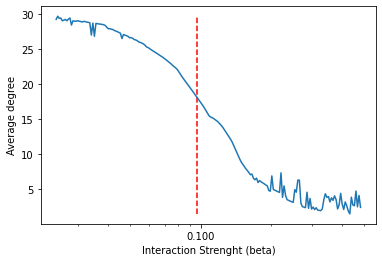

In [47]:
import matplotlib

avs_degrees=np.zeros(len(control_history))
for it,control in enumerate(control_history):
    av_degree = average_degree(G,control,budget)
    avs_degrees[it]=av_degree

fig,ax = plt.subplots()

ax.plot(beta_list,avs_degrees)
ax.set_xscale(value='log')


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.vlines(beta_crit,ymin=min(avs_degrees),ymax=max(avs_degrees),linestyles='dashed',color='red',label='beta')
ax.set_xlabel(r'Interaction Strenght (beta)')

#string_name='RealNet_Average'+{}
path = 'C:/Users/zuzan/OneDrive/Dokumenty/Master-Papers/Masters_figures/'


plt.savefig(path+params_name(normal_params)+'.png'.format(*[normal_params[x] for x in ['step_size','fixed_point_iter','iim_iter']]))
plt.show()


In [48]:
class monte_carlo_simulations:
    def __init__(self,graph,background_field):
        self.graph = graph
        self.graph_size = len(self.graph.nodes())
        self.adj_matrix = nx.to_numpy_matrix(graph)
        half_size = int(self.graph_size/2)
        if self.graph_size%2==0:
            spins = np.concatenate([np.ones(half_size),(-1)*np.ones(half_size)])
        else:
            spins = np.concatenate([np.ones(half_size+1),(-1)*np.ones(half_size)])
        np.random.shuffle(spins)
        self.init_spins = spins
        self.background_field = background_field
        
mc_system = monte_carlo_simulations(G,h)

In [49]:
from networkx.algorithms.centrality import closeness_centrality
import random 


def fixed_point(system,total_field,beta=beta_crit):
    mag_old = system.init_mag
    for it in range(system.fixed_point_iter):
        mag_new = system.magnetisation(mag_old,beta,total_field)
        if np.abs(np.mean(mag_new)-np.mean(mag_old))<system.fp_tol_fac: 
            break
        mag_old = mag_new
        if i+1==self.fixed_point_iter:
            print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.')
    return mag_new
    
def monte_carlo_glauber(system,control,repeat_factor=1000,beta=beta_crit):
    total_mag_history = np.zeros(repeat_factor)
    mag_old = system.init_spins
    
    for jt in range(repeat_factor):
        for it in range(system.graph_size):
            
            spin_int = random.randint(0,len(system.init_spins)-1)
            surr_spin = float(system.adj_matrix[spin_int,:]@mag_old)
            
            delta_e = 2*mag_old[spin_int]*(surr_spin+control[spin_int])
            
            prob = random.uniform(0, 1)
            if prob <=(np.exp(-delta_e*beta)/(1+np.exp(-delta_e*beta))):
                mag_rev = (-1)*mag_old[spin_int]
                mag_old[spin_int] = mag_rev
        total_mag = np.sum(mag_old)
        total_mag_history[jt] = total_mag
        if len(total_mag_history)>11:
            previous_average_mag=np.mean(total_mag_history[jt-10:jt-1])
        elif jt>0 and len(total_mag_history)<11:
            previous_average_mag = np.mean(total_mag_history[0,jt-1])
        elif jt==0:
            previous_average_mag=0.0
        if np.abs(total_mag-previous_average_mag)<1e-8:
            mag_final = total_mag
            print('repeated ',int(jt),' times. Obtained value: ',mag_final)
            break
        if (jt+1)==repeat_factor:
            print('Failed to stabilise.')
            mag_final = total_mag
    return mag_final

    
def degree(system,budget,beta=beta_crit):
    sum_degree = np.sum([system.graph.degree[node] for node in system.graph.nodes])
    control_field = np.array([(system.graph.degree[node]/sum_degree)*budget for node in system.graph.nodes])
    
    assert np.round(np.sum(control_field),3)==budget

    tot_field = np.array(system.background_field+control_field)
    
    mag=fixed_point(system,tot_field)

    return np.sum(mag)

def centrality(system,budget,beta=beta_crit):
    centrality = closeness_centrality(system.graph)
    sum_centrality=sum(centrality.values())
    control_field = np.array([(centrality[node]/sum_centrality)*budget for node in system.graph.nodes])
    
    assert np.round(np.sum(control_field),3)==budget
    
    tot_field = np.array(system.background_field+control_field)
    #mag=monte_carlo_glauber(system,tot_field)
    mag=fixed_point(system,tot_field)

    return np.sum(mag)


def random_set(system,budget,beta=beta_crit):
    random_arr = [int(100*random.random()) for i in range(system.graph_size)]
    random_dic = {i:k for i,k in zip(system.graph.nodes,random_arr)}
    sum_random = np.sum(random_arr)
    control_field = np.array([(random_dic[node]/sum_random)*budget for node in system.graph.nodes])
    
    assert np.round(np.sum(control_field),3)==budget
    
    tot_field = np.array(system.background_field+control_field)
    #mag=monte_carlo_glauber(system,tot_field)

    mag=fixed_point(system,tot_field)

    return np.sum(mag) if np.all(mag!=None) else mag

def randomly(system,budget,beta=beta_crit):
    iters = 20
    mags=np.zeros(iters)
    for i in range(iters):
        mag=random_set(system,budget,beta)
        if np.all(mag!=None):
            mags[i]=mag
    return np.mean(mags)



In [50]:
budgets = np.arange(1,200,5)
system = mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=10000,step_size=5.0)

all_types={'MF':[],'Central':[],'Random':[],'Degree':[]}

for budget in budgets:
    print(budget)

    #print('MF')
    control,final_mag=system.MF_IIM(budget,beta_crit)
    mag_mf = np.sum(final_mag)
    all_types['MF'].append(mag_mf)
    
    #print('Central')
    mag_c= centrality(system,budget)
    all_types['Central'].append(mag_c)

    #print('Degree')
    mag_d = degree(system,budget)
    all_types['Degree'].append(mag_d)

    #print('Random')
    mag_r= random_set(system,budget)
    all_types['Random'].append(mag_r)




1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96
101
106
111
116
121
126
131
136
141
146
151
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
156
161
166
171
176
181
186
191
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
196


ValueError: x and y must have same first dimension, but have shapes (13,) and (40,)

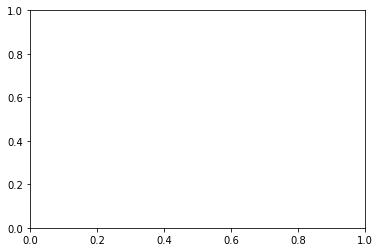

In [66]:
fig,ax=plt.subplots()

ax.plot(budgets[:13],all_types['MF'],label='MF')
ax.plot(budgets[:12],all_types['Central'],label='Central')
ax.plot(budgets[:12],all_types['Random'],label='Random')
ax.plot(budgets[:12],all_types['Degree'],label='Degree')
ax.legend()
plt.show()

In [ ]:
system = mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=5000,step_size=0.05)

degree(system,budget=12.0)

In [51]:
dict(G.degree).values()

dict_values([1, 11, 34, 27, 21, 4, 15, 12, 6, 3, 12, 4, 16, 10, 8, 9, 4, 6, 6, 8, 3, 1, 3, 3, 4, 4, 4, 8, 8, 3, 2, 5, 5, 4, 4, 4, 2, 4, 3, 7, 14, 7, 6, 14, 7, 10, 4, 4, 2, 4, 6, 8, 12, 4, 5, 3, 3, 27, 4, 3, 3, 10, 4, 3, 3, 3, 1, 3, 3, 19, 10, 9, 9, 8, 3, 2, 2, 2, 8, 4, 4, 4, 1, 4, 10, 5, 2, 2, 6, 3, 15, 11, 10, 11, 8, 5, 3, 5, 5, 4, 2, 2, 5, 15, 19, 2, 2, 2, 2, 3, 6, 2, 18, 3, 9, 17, 5, 4, 11, 8, 7, 2, 6, 5, 1, 2, 3, 2, 1, 5, 2, 2, 1, 3, 3, 3, 4, 12, 4, 5, 4, 6, 4, 3, 3, 3, 2, 2, 2, 6, 2, 3, 3, 4, 7, 7, 2, 3, 11, 5, 5, 5, 5, 5, 12, 4, 4, 4, 3, 6, 7, 7, 2, 3, 3, 4, 2, 2, 12, 6, 14, 3, 2, 3, 6, 2, 3, 3, 3, 1, 6, 6, 5, 2, 4, 8, 4, 2, 6, 5, 4, 4, 3, 2, 2, 5, 7, 3, 18, 6, 6, 5, 5, 4, 7, 4, 6, 4, 3, 3, 1, 10, 8, 12, 12, 3, 3, 7, 7, 7, 7, 3, 3, 2, 10, 9, 13, 7, 11, 11, 7, 11, 7, 5, 5, 4, 8, 9, 7, 6, 6, 3, 6, 7, 8, 6, 4, 2, 2, 1, 2, 2, 2, 1, 2, 5, 1, 1, 4, 3, 3, 6, 2, 2, 1, 2, 2, 6, 5, 9, 5, 2, 6, 6, 6, 6, 6, 2, 4, 4, 4, 4, 2, 1, 2, 2, 3, 3, 2, 2, 1, 2, 5, 1, 3, 5, 3, 2, 2, 2, 7, 3, 4, 3, 1, 2

In [98]:
budgets = np.arange(1,200,5)
print(len(budgets))

40
